In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os
import random

In [9]:
import torch
model = torch.hub.load('pytorch/vision:v0.9.0', 'squeezenet1_1', pretrained=False)
model.eval()

Using cache found in C:\Users\Otakuking/.cache\torch\hub\pytorch_vision_v0.9.0


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [10]:
batch_size = 16
learning_rate = 0.0001
random_seed = 555
random.seed(random_seed)
torch.manual_seed(random_seed)

transforms = transforms.Compose([
    transforms.Resize(48),
    transforms.CenterCrop(48),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4927, 0.4927, 0.4927], std=[0.4999, 0.4999, 0.4999]),
])
train_dataset = datasets.ImageFolder(root='emotion3/train/', transform=transforms)
test_dataset = datasets.ImageFolder(root='emotion3/test/', transform=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [11]:
def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.4927, 0.4927, 0.4927])
    std = np.array([0.4999, 0.4999, 0.4999])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

images-size: torch.Size([16, 3, 48, 48])
out-size: torch.Size([3, 102, 402])


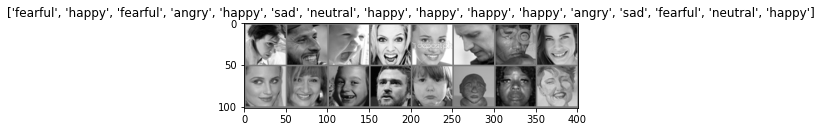

In [12]:
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [13]:
net = model
net = net.cuda() if device else net
net

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, 
                 betas=(0.9, 0.999), 
                 eps=1e-08, 
                 weight_decay=0, 
                 amsgrad=False)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [15]:
n_epochs = 50
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'Squeezenet1.1_lr0.001_batch64_epoch50_imsize48_CalcMeanStd_emotion6ver.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/50], Step [0/1248], Loss: 6.9083
Epoch [1/50], Step [20/1248], Loss: 5.8294
Epoch [1/50], Step [40/1248], Loss: 1.9189
Epoch [1/50], Step [60/1248], Loss: 2.0376
Epoch [1/50], Step [80/1248], Loss: 1.8366
Epoch [1/50], Step [100/1248], Loss: 1.7967
Epoch [1/50], Step [120/1248], Loss: 1.8857
Epoch [1/50], Step [140/1248], Loss: 2.0586
Epoch [1/50], Step [160/1248], Loss: 1.8698
Epoch [1/50], Step [180/1248], Loss: 2.0077
Epoch [1/50], Step [200/1248], Loss: 1.7683
Epoch [1/50], Step [220/1248], Loss: 2.0300
Epoch [1/50], Step [240/1248], Loss: 1.6982
Epoch [1/50], Step [260/1248], Loss: 1.7704
Epoch [1/50], Step [280/1248], Loss: 1.6894
Epoch [1/50], Step [300/1248], Loss: 1.6707
Epoch [1/50], Step [320/1248], Loss: 1.7794
Epoch [1/50], Step [340/1248], Loss: 1.6970
Epoch [1/50], Step [360/1248], Loss: 1.7376
Epoch [1/50], Step [380/1248], Loss: 1.7827
Epoch [1/50], Step [400/1248], Loss: 1.8391
Epoch [1/50], Step [420/1248], Loss: 1.9037
Epoch [1/50], Step [440/1248]

Epoch [3/50], Step [1080/1248], Loss: 1.8490
Epoch [3/50], Step [1100/1248], Loss: 1.3617
Epoch [3/50], Step [1120/1248], Loss: 1.3801
Epoch [3/50], Step [1140/1248], Loss: 1.3960
Epoch [3/50], Step [1160/1248], Loss: 1.2914
Epoch [3/50], Step [1180/1248], Loss: 1.3782
Epoch [3/50], Step [1200/1248], Loss: 1.8409
Epoch [3/50], Step [1220/1248], Loss: 1.3463
Epoch [3/50], Step [1240/1248], Loss: 1.5613

train-loss: 1.7198, train-acc: 36.1723
validation loss: 1.6011, validation acc: 39.3399

Improvement-Detected, save-model
Epoch 4

Epoch [4/50], Step [0/1248], Loss: 1.3151
Epoch [4/50], Step [20/1248], Loss: 1.6204
Epoch [4/50], Step [40/1248], Loss: 1.3601
Epoch [4/50], Step [60/1248], Loss: 1.6029
Epoch [4/50], Step [80/1248], Loss: 1.5022
Epoch [4/50], Step [100/1248], Loss: 1.5183
Epoch [4/50], Step [120/1248], Loss: 1.2238
Epoch [4/50], Step [140/1248], Loss: 1.7552
Epoch [4/50], Step [160/1248], Loss: 1.2784
Epoch [4/50], Step [180/1248], Loss: 1.4691
Epoch [4/50], Step [200/1248]

Epoch [6/50], Step [840/1248], Loss: 1.5355
Epoch [6/50], Step [860/1248], Loss: 1.2298
Epoch [6/50], Step [880/1248], Loss: 1.5382
Epoch [6/50], Step [900/1248], Loss: 1.4764
Epoch [6/50], Step [920/1248], Loss: 1.0095
Epoch [6/50], Step [940/1248], Loss: 1.4526
Epoch [6/50], Step [960/1248], Loss: 1.1542
Epoch [6/50], Step [980/1248], Loss: 1.3736
Epoch [6/50], Step [1000/1248], Loss: 1.2611
Epoch [6/50], Step [1020/1248], Loss: 1.2686
Epoch [6/50], Step [1040/1248], Loss: 1.4050
Epoch [6/50], Step [1060/1248], Loss: 1.2965
Epoch [6/50], Step [1080/1248], Loss: 1.8910
Epoch [6/50], Step [1100/1248], Loss: 1.7935
Epoch [6/50], Step [1120/1248], Loss: 1.6969
Epoch [6/50], Step [1140/1248], Loss: 1.3728
Epoch [6/50], Step [1160/1248], Loss: 1.5905
Epoch [6/50], Step [1180/1248], Loss: 1.2960
Epoch [6/50], Step [1200/1248], Loss: 1.3057
Epoch [6/50], Step [1220/1248], Loss: 1.4962
Epoch [6/50], Step [1240/1248], Loss: 1.2926

train-loss: 1.5669, train-acc: 45.4008
validation loss: 1.5204

Epoch [9/50], Step [620/1248], Loss: 1.5404
Epoch [9/50], Step [640/1248], Loss: 1.0714
Epoch [9/50], Step [660/1248], Loss: 1.0531
Epoch [9/50], Step [680/1248], Loss: 0.8663
Epoch [9/50], Step [700/1248], Loss: 0.8207
Epoch [9/50], Step [720/1248], Loss: 1.3727
Epoch [9/50], Step [740/1248], Loss: 1.6123
Epoch [9/50], Step [760/1248], Loss: 1.1595
Epoch [9/50], Step [780/1248], Loss: 1.3856
Epoch [9/50], Step [800/1248], Loss: 1.3103
Epoch [9/50], Step [820/1248], Loss: 1.1918
Epoch [9/50], Step [840/1248], Loss: 1.1765
Epoch [9/50], Step [860/1248], Loss: 1.3671
Epoch [9/50], Step [880/1248], Loss: 1.0453
Epoch [9/50], Step [900/1248], Loss: 1.4384
Epoch [9/50], Step [920/1248], Loss: 1.2386
Epoch [9/50], Step [940/1248], Loss: 1.3701
Epoch [9/50], Step [960/1248], Loss: 1.0349
Epoch [9/50], Step [980/1248], Loss: 1.1592
Epoch [9/50], Step [1000/1248], Loss: 1.5275
Epoch [9/50], Step [1020/1248], Loss: 1.1167
Epoch [9/50], Step [1040/1248], Loss: 1.4450
Epoch [9/50], Step [1060/1248

Epoch [12/50], Step [340/1248], Loss: 1.2576
Epoch [12/50], Step [360/1248], Loss: 0.9395
Epoch [12/50], Step [380/1248], Loss: 0.9889
Epoch [12/50], Step [400/1248], Loss: 1.2322
Epoch [12/50], Step [420/1248], Loss: 0.8679
Epoch [12/50], Step [440/1248], Loss: 1.2636
Epoch [12/50], Step [460/1248], Loss: 1.2524
Epoch [12/50], Step [480/1248], Loss: 0.8767
Epoch [12/50], Step [500/1248], Loss: 1.3847
Epoch [12/50], Step [520/1248], Loss: 1.3248
Epoch [12/50], Step [540/1248], Loss: 1.2375
Epoch [12/50], Step [560/1248], Loss: 0.9016
Epoch [12/50], Step [580/1248], Loss: 0.9024
Epoch [12/50], Step [600/1248], Loss: 1.2307
Epoch [12/50], Step [620/1248], Loss: 1.5359
Epoch [12/50], Step [640/1248], Loss: 1.1783
Epoch [12/50], Step [660/1248], Loss: 1.0699
Epoch [12/50], Step [680/1248], Loss: 0.7405
Epoch [12/50], Step [700/1248], Loss: 1.0455
Epoch [12/50], Step [720/1248], Loss: 1.0142
Epoch [12/50], Step [740/1248], Loss: 1.2729
Epoch [12/50], Step [760/1248], Loss: 1.2607
Epoch [12/

Epoch [15/50], Step [60/1248], Loss: 0.8167
Epoch [15/50], Step [80/1248], Loss: 1.1248
Epoch [15/50], Step [100/1248], Loss: 0.9062
Epoch [15/50], Step [120/1248], Loss: 0.9753
Epoch [15/50], Step [140/1248], Loss: 1.0657
Epoch [15/50], Step [160/1248], Loss: 0.9805
Epoch [15/50], Step [180/1248], Loss: 1.0199
Epoch [15/50], Step [200/1248], Loss: 0.9486
Epoch [15/50], Step [220/1248], Loss: 0.8001
Epoch [15/50], Step [240/1248], Loss: 0.9347
Epoch [15/50], Step [260/1248], Loss: 0.9229
Epoch [15/50], Step [280/1248], Loss: 1.1936
Epoch [15/50], Step [300/1248], Loss: 1.0094
Epoch [15/50], Step [320/1248], Loss: 1.1257
Epoch [15/50], Step [340/1248], Loss: 0.4303
Epoch [15/50], Step [360/1248], Loss: 0.8878
Epoch [15/50], Step [380/1248], Loss: 0.9826
Epoch [15/50], Step [400/1248], Loss: 1.2776
Epoch [15/50], Step [420/1248], Loss: 0.9630
Epoch [15/50], Step [440/1248], Loss: 0.9395
Epoch [15/50], Step [460/1248], Loss: 0.6018
Epoch [15/50], Step [480/1248], Loss: 1.1404
Epoch [15/50

Epoch [17/50], Step [1100/1248], Loss: 0.7954
Epoch [17/50], Step [1120/1248], Loss: 0.9865
Epoch [17/50], Step [1140/1248], Loss: 0.7444
Epoch [17/50], Step [1160/1248], Loss: 0.6994
Epoch [17/50], Step [1180/1248], Loss: 0.9434
Epoch [17/50], Step [1200/1248], Loss: 0.7791
Epoch [17/50], Step [1220/1248], Loss: 1.2006
Epoch [17/50], Step [1240/1248], Loss: 0.8654

train-loss: 1.2702, train-acc: 65.8216
validation loss: 1.4265, validation acc: 47.4709

Epoch 18

Epoch [18/50], Step [0/1248], Loss: 0.7581
Epoch [18/50], Step [20/1248], Loss: 0.5004
Epoch [18/50], Step [40/1248], Loss: 0.9163
Epoch [18/50], Step [60/1248], Loss: 1.1507
Epoch [18/50], Step [80/1248], Loss: 0.8884
Epoch [18/50], Step [100/1248], Loss: 0.7822
Epoch [18/50], Step [120/1248], Loss: 0.8808
Epoch [18/50], Step [140/1248], Loss: 0.7535
Epoch [18/50], Step [160/1248], Loss: 0.7023
Epoch [18/50], Step [180/1248], Loss: 0.8631
Epoch [18/50], Step [200/1248], Loss: 0.6862
Epoch [18/50], Step [220/1248], Loss: 1.033

Epoch [20/50], Step [840/1248], Loss: 0.7920
Epoch [20/50], Step [860/1248], Loss: 1.0044
Epoch [20/50], Step [880/1248], Loss: 0.6352
Epoch [20/50], Step [900/1248], Loss: 0.9606
Epoch [20/50], Step [920/1248], Loss: 0.5837
Epoch [20/50], Step [940/1248], Loss: 0.7092
Epoch [20/50], Step [960/1248], Loss: 0.4521
Epoch [20/50], Step [980/1248], Loss: 0.7980
Epoch [20/50], Step [1000/1248], Loss: 0.7577
Epoch [20/50], Step [1020/1248], Loss: 0.9932
Epoch [20/50], Step [1040/1248], Loss: 0.8231
Epoch [20/50], Step [1060/1248], Loss: 0.8993
Epoch [20/50], Step [1080/1248], Loss: 0.9031
Epoch [20/50], Step [1100/1248], Loss: 1.1859
Epoch [20/50], Step [1120/1248], Loss: 0.6598
Epoch [20/50], Step [1140/1248], Loss: 0.8502
Epoch [20/50], Step [1160/1248], Loss: 0.4026
Epoch [20/50], Step [1180/1248], Loss: 0.5786
Epoch [20/50], Step [1200/1248], Loss: 0.8149
Epoch [20/50], Step [1220/1248], Loss: 0.6936
Epoch [20/50], Step [1240/1248], Loss: 0.9217

train-loss: 1.2033, train-acc: 70.6162
va

Epoch [23/50], Step [560/1248], Loss: 0.4720
Epoch [23/50], Step [580/1248], Loss: 0.6763
Epoch [23/50], Step [600/1248], Loss: 1.0137
Epoch [23/50], Step [620/1248], Loss: 0.8398
Epoch [23/50], Step [640/1248], Loss: 0.8810
Epoch [23/50], Step [660/1248], Loss: 0.3685
Epoch [23/50], Step [680/1248], Loss: 0.4459
Epoch [23/50], Step [700/1248], Loss: 0.5432
Epoch [23/50], Step [720/1248], Loss: 0.7070
Epoch [23/50], Step [740/1248], Loss: 0.7656
Epoch [23/50], Step [760/1248], Loss: 1.1887
Epoch [23/50], Step [780/1248], Loss: 0.4820
Epoch [23/50], Step [800/1248], Loss: 0.4796
Epoch [23/50], Step [820/1248], Loss: 0.5374
Epoch [23/50], Step [840/1248], Loss: 0.7103
Epoch [23/50], Step [860/1248], Loss: 1.2241
Epoch [23/50], Step [880/1248], Loss: 0.8262
Epoch [23/50], Step [900/1248], Loss: 0.4737
Epoch [23/50], Step [920/1248], Loss: 0.5349
Epoch [23/50], Step [940/1248], Loss: 0.5394
Epoch [23/50], Step [960/1248], Loss: 0.5344
Epoch [23/50], Step [980/1248], Loss: 0.7025
Epoch [23/

Epoch [26/50], Step [280/1248], Loss: 0.1853
Epoch [26/50], Step [300/1248], Loss: 0.7476
Epoch [26/50], Step [320/1248], Loss: 0.4203
Epoch [26/50], Step [340/1248], Loss: 0.6742
Epoch [26/50], Step [360/1248], Loss: 0.4182
Epoch [26/50], Step [380/1248], Loss: 0.3198
Epoch [26/50], Step [400/1248], Loss: 0.3361
Epoch [26/50], Step [420/1248], Loss: 0.5559
Epoch [26/50], Step [440/1248], Loss: 0.5854
Epoch [26/50], Step [460/1248], Loss: 0.4993
Epoch [26/50], Step [480/1248], Loss: 0.3452
Epoch [26/50], Step [500/1248], Loss: 0.8454
Epoch [26/50], Step [520/1248], Loss: 0.5860
Epoch [26/50], Step [540/1248], Loss: 0.9003
Epoch [26/50], Step [560/1248], Loss: 0.4699
Epoch [26/50], Step [580/1248], Loss: 0.3420
Epoch [26/50], Step [600/1248], Loss: 0.7561
Epoch [26/50], Step [620/1248], Loss: 0.4983
Epoch [26/50], Step [640/1248], Loss: 0.3723
Epoch [26/50], Step [660/1248], Loss: 0.5314
Epoch [26/50], Step [680/1248], Loss: 0.4344
Epoch [26/50], Step [700/1248], Loss: 0.4599
Epoch [26/

Epoch [29/50], Step [20/1248], Loss: 0.8992
Epoch [29/50], Step [40/1248], Loss: 0.1994
Epoch [29/50], Step [60/1248], Loss: 0.7247
Epoch [29/50], Step [80/1248], Loss: 0.3912
Epoch [29/50], Step [100/1248], Loss: 0.3319
Epoch [29/50], Step [120/1248], Loss: 0.1832
Epoch [29/50], Step [140/1248], Loss: 0.4128
Epoch [29/50], Step [160/1248], Loss: 0.1369
Epoch [29/50], Step [180/1248], Loss: 0.4341
Epoch [29/50], Step [200/1248], Loss: 0.3451
Epoch [29/50], Step [220/1248], Loss: 0.5651
Epoch [29/50], Step [240/1248], Loss: 0.2723
Epoch [29/50], Step [260/1248], Loss: 0.2577
Epoch [29/50], Step [280/1248], Loss: 0.5165
Epoch [29/50], Step [300/1248], Loss: 0.4109
Epoch [29/50], Step [320/1248], Loss: 0.4058
Epoch [29/50], Step [340/1248], Loss: 0.3439
Epoch [29/50], Step [360/1248], Loss: 0.4720
Epoch [29/50], Step [380/1248], Loss: 0.4789
Epoch [29/50], Step [400/1248], Loss: 0.4587
Epoch [29/50], Step [420/1248], Loss: 0.6373
Epoch [29/50], Step [440/1248], Loss: 0.4848
Epoch [29/50],

Epoch [31/50], Step [1060/1248], Loss: 0.6152
Epoch [31/50], Step [1080/1248], Loss: 0.5504
Epoch [31/50], Step [1100/1248], Loss: 0.2188
Epoch [31/50], Step [1120/1248], Loss: 0.3996
Epoch [31/50], Step [1140/1248], Loss: 0.3146
Epoch [31/50], Step [1160/1248], Loss: 0.4923
Epoch [31/50], Step [1180/1248], Loss: 0.4669
Epoch [31/50], Step [1200/1248], Loss: 0.3325
Epoch [31/50], Step [1220/1248], Loss: 0.1487
Epoch [31/50], Step [1240/1248], Loss: 0.6189

train-loss: 0.9813, train-acc: 84.8297
validation loss: 1.6368, validation acc: 48.8619

Epoch 32

Epoch [32/50], Step [0/1248], Loss: 0.3629
Epoch [32/50], Step [20/1248], Loss: 0.4899
Epoch [32/50], Step [40/1248], Loss: 0.5510
Epoch [32/50], Step [60/1248], Loss: 0.4290
Epoch [32/50], Step [80/1248], Loss: 0.3122
Epoch [32/50], Step [100/1248], Loss: 0.3121
Epoch [32/50], Step [120/1248], Loss: 0.1480
Epoch [32/50], Step [140/1248], Loss: 0.1230
Epoch [32/50], Step [160/1248], Loss: 0.4654
Epoch [32/50], Step [180/1248], Loss: 0.2

Epoch [34/50], Step [780/1248], Loss: 0.2160
Epoch [34/50], Step [800/1248], Loss: 0.2247
Epoch [34/50], Step [820/1248], Loss: 0.4689
Epoch [34/50], Step [840/1248], Loss: 0.5231
Epoch [34/50], Step [860/1248], Loss: 0.1839
Epoch [34/50], Step [880/1248], Loss: 0.2684
Epoch [34/50], Step [900/1248], Loss: 0.1723
Epoch [34/50], Step [920/1248], Loss: 0.6572
Epoch [34/50], Step [940/1248], Loss: 0.4190
Epoch [34/50], Step [960/1248], Loss: 0.4943
Epoch [34/50], Step [980/1248], Loss: 0.6427
Epoch [34/50], Step [1000/1248], Loss: 0.6047
Epoch [34/50], Step [1020/1248], Loss: 0.3442
Epoch [34/50], Step [1040/1248], Loss: 0.1660
Epoch [34/50], Step [1060/1248], Loss: 0.7819
Epoch [34/50], Step [1080/1248], Loss: 0.3077
Epoch [34/50], Step [1100/1248], Loss: 0.1429
Epoch [34/50], Step [1120/1248], Loss: 0.4222
Epoch [34/50], Step [1140/1248], Loss: 0.3662
Epoch [34/50], Step [1160/1248], Loss: 0.2849
Epoch [34/50], Step [1180/1248], Loss: 0.3405
Epoch [34/50], Step [1200/1248], Loss: 0.4832

Epoch [37/50], Step [500/1248], Loss: 0.1632
Epoch [37/50], Step [520/1248], Loss: 0.1946
Epoch [37/50], Step [540/1248], Loss: 1.0301
Epoch [37/50], Step [560/1248], Loss: 0.1241
Epoch [37/50], Step [580/1248], Loss: 0.3510
Epoch [37/50], Step [600/1248], Loss: 0.1543
Epoch [37/50], Step [620/1248], Loss: 0.2668
Epoch [37/50], Step [640/1248], Loss: 0.3859
Epoch [37/50], Step [660/1248], Loss: 0.4006
Epoch [37/50], Step [680/1248], Loss: 0.3628
Epoch [37/50], Step [700/1248], Loss: 0.0435
Epoch [37/50], Step [720/1248], Loss: 0.2658
Epoch [37/50], Step [740/1248], Loss: 0.3370
Epoch [37/50], Step [760/1248], Loss: 0.0493
Epoch [37/50], Step [780/1248], Loss: 0.2444
Epoch [37/50], Step [800/1248], Loss: 1.0111
Epoch [37/50], Step [820/1248], Loss: 0.3202
Epoch [37/50], Step [840/1248], Loss: 0.0382
Epoch [37/50], Step [860/1248], Loss: 0.4182
Epoch [37/50], Step [880/1248], Loss: 0.1783
Epoch [37/50], Step [900/1248], Loss: 0.2436
Epoch [37/50], Step [920/1248], Loss: 0.4020
Epoch [37/

Epoch [40/50], Step [220/1248], Loss: 0.5367
Epoch [40/50], Step [240/1248], Loss: 0.0473
Epoch [40/50], Step [260/1248], Loss: 0.1539
Epoch [40/50], Step [280/1248], Loss: 0.3216
Epoch [40/50], Step [300/1248], Loss: 0.3202
Epoch [40/50], Step [320/1248], Loss: 0.2014
Epoch [40/50], Step [340/1248], Loss: 0.2926
Epoch [40/50], Step [360/1248], Loss: 0.0810
Epoch [40/50], Step [380/1248], Loss: 0.2867
Epoch [40/50], Step [400/1248], Loss: 0.1640
Epoch [40/50], Step [420/1248], Loss: 0.1813
Epoch [40/50], Step [440/1248], Loss: 0.0731
Epoch [40/50], Step [460/1248], Loss: 0.3536
Epoch [40/50], Step [480/1248], Loss: 0.3605
Epoch [40/50], Step [500/1248], Loss: 0.3208
Epoch [40/50], Step [520/1248], Loss: 0.5841
Epoch [40/50], Step [540/1248], Loss: 0.1881
Epoch [40/50], Step [560/1248], Loss: 0.1619
Epoch [40/50], Step [580/1248], Loss: 0.0809
Epoch [40/50], Step [600/1248], Loss: 0.0717
Epoch [40/50], Step [620/1248], Loss: 0.3968
Epoch [40/50], Step [640/1248], Loss: 0.5562
Epoch [40/

validation loss: 1.9106, validation acc: 48.8366

Epoch 43

Epoch [43/50], Step [0/1248], Loss: 0.0875
Epoch [43/50], Step [20/1248], Loss: 0.1731
Epoch [43/50], Step [40/1248], Loss: 0.2041
Epoch [43/50], Step [60/1248], Loss: 0.0084
Epoch [43/50], Step [80/1248], Loss: 0.2502
Epoch [43/50], Step [100/1248], Loss: 0.2394
Epoch [43/50], Step [120/1248], Loss: 0.0556
Epoch [43/50], Step [140/1248], Loss: 0.0934
Epoch [43/50], Step [160/1248], Loss: 0.0799
Epoch [43/50], Step [180/1248], Loss: 0.3603
Epoch [43/50], Step [200/1248], Loss: 0.4129
Epoch [43/50], Step [220/1248], Loss: 0.1818
Epoch [43/50], Step [240/1248], Loss: 0.2664
Epoch [43/50], Step [260/1248], Loss: 0.2609
Epoch [43/50], Step [280/1248], Loss: 0.3107
Epoch [43/50], Step [300/1248], Loss: 0.4156
Epoch [43/50], Step [320/1248], Loss: 0.4883
Epoch [43/50], Step [340/1248], Loss: 0.2155
Epoch [43/50], Step [360/1248], Loss: 0.0966
Epoch [43/50], Step [380/1248], Loss: 0.2578
Epoch [43/50], Step [400/1248], Loss: 0.6099
E

Epoch [45/50], Step [1020/1248], Loss: 0.1429
Epoch [45/50], Step [1040/1248], Loss: 0.1325
Epoch [45/50], Step [1060/1248], Loss: 0.0855
Epoch [45/50], Step [1080/1248], Loss: 0.1659
Epoch [45/50], Step [1100/1248], Loss: 0.4751
Epoch [45/50], Step [1120/1248], Loss: 0.0570
Epoch [45/50], Step [1140/1248], Loss: 0.0497
Epoch [45/50], Step [1160/1248], Loss: 0.5787
Epoch [45/50], Step [1180/1248], Loss: 0.2865
Epoch [45/50], Step [1200/1248], Loss: 0.1124
Epoch [45/50], Step [1220/1248], Loss: 0.0239
Epoch [45/50], Step [1240/1248], Loss: 0.4446

train-loss: 0.7672, train-acc: 92.0792
validation loss: 1.9844, validation acc: 46.0799

Epoch 46

Epoch [46/50], Step [0/1248], Loss: 0.1617
Epoch [46/50], Step [20/1248], Loss: 0.5816
Epoch [46/50], Step [40/1248], Loss: 0.1119
Epoch [46/50], Step [60/1248], Loss: 0.0822
Epoch [46/50], Step [80/1248], Loss: 0.2906
Epoch [46/50], Step [100/1248], Loss: 0.0912
Epoch [46/50], Step [120/1248], Loss: 0.0234
Epoch [46/50], Step [140/1248], Loss: 0

Epoch [48/50], Step [740/1248], Loss: 0.0276
Epoch [48/50], Step [760/1248], Loss: 0.3294
Epoch [48/50], Step [780/1248], Loss: 0.2440
Epoch [48/50], Step [800/1248], Loss: 0.1326
Epoch [48/50], Step [820/1248], Loss: 0.0608
Epoch [48/50], Step [840/1248], Loss: 0.0566
Epoch [48/50], Step [860/1248], Loss: 0.0170
Epoch [48/50], Step [880/1248], Loss: 0.0470
Epoch [48/50], Step [900/1248], Loss: 0.0873
Epoch [48/50], Step [920/1248], Loss: 0.2100
Epoch [48/50], Step [940/1248], Loss: 0.0917
Epoch [48/50], Step [960/1248], Loss: 0.2145
Epoch [48/50], Step [980/1248], Loss: 0.1623
Epoch [48/50], Step [1000/1248], Loss: 0.1313
Epoch [48/50], Step [1020/1248], Loss: 0.1859
Epoch [48/50], Step [1040/1248], Loss: 0.0657
Epoch [48/50], Step [1060/1248], Loss: 0.2921
Epoch [48/50], Step [1080/1248], Loss: 0.1865
Epoch [48/50], Step [1100/1248], Loss: 0.0186
Epoch [48/50], Step [1120/1248], Loss: 0.7297
Epoch [48/50], Step [1140/1248], Loss: 0.0363
Epoch [48/50], Step [1160/1248], Loss: 0.2926
E

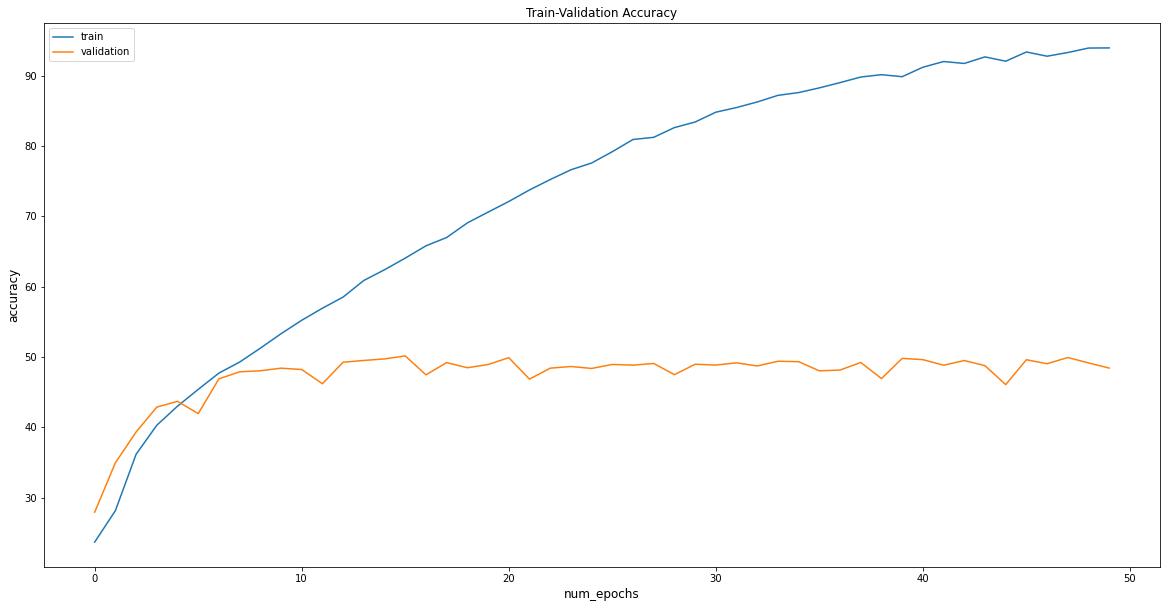

In [16]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

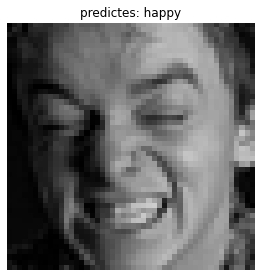

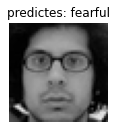

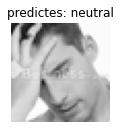

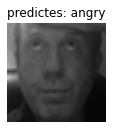

In [17]:
def visualize_model(net, num_images=4):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if device:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if device else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
            imshow(inputs[j])
            
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(net)
plt.ioff()